# E10. 인물 모드 문제점 찾기

## ◈ 프로젝트 목표


## ◈ 목차
### Step 1. 인물모드 직접 해 보기
### Step 2. 사진에서 문제점 찾기¶
### Step 3. 해결 방법을 제안해 보기
    세그멘테이션의 한계
    피사계 심도 이해하기¶
    3D Depth Camera 활용하기¶
    깊이 영상(Depth image) 활용하기¶
    IR(적외선)을 활용한 사례

## Step 1. 인물모드 직접 해 보기
여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

In [41]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [42]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
height0, width0, _ = img_orig.shape
print (img_orig.shape)

(1836, 3264, 3)


##  - 인물사진 

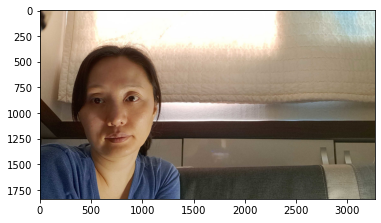

In [43]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_RGB2BGR))
plt.show()

## - 시맨틱 세그멘테이션

In [44]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [45]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj56/aiffel/human_segmentation/models
model loaded successfully!


In [46]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1836, 3264, 3) (288, 513, 3) 15


In [47]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

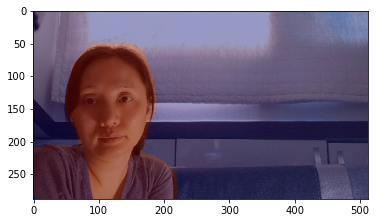

In [48]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## - 셸로우 포커스

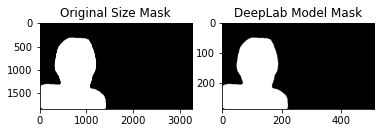

In [49]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

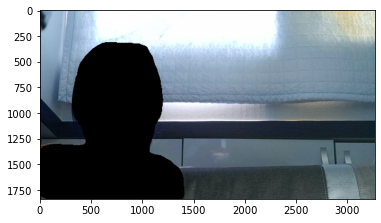

In [50]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

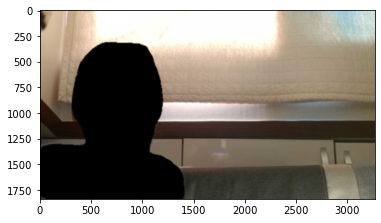

In [51]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

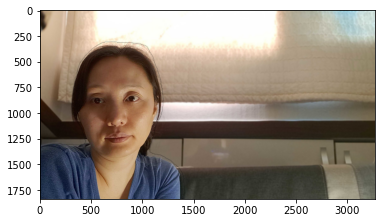

In [58]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
img_concat = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
plt.imshow(img_concat)
plt.show()

## - 배경 사진 바꾸기

In [63]:
import os
backimg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/flower.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
backimg_orig = cv2.imread(backimg_path) 
print (backimg_orig.shape)

(341, 512, 3)


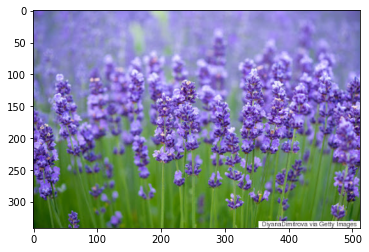

(341, 512, 3)


In [64]:
back = cv2.cvtColor(backimg_orig, cv2.COLOR_BGR2RGB)
plt.imshow(back)
plt.show()
print(back.shape)

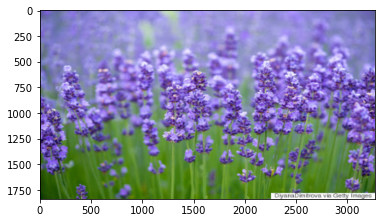

In [65]:
back = cv2.resize(back, (width0, height0))
plt.imshow(back)
plt.show()

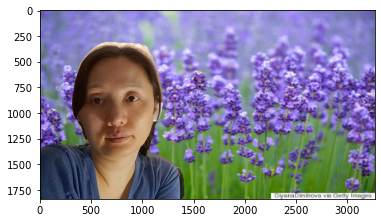

In [66]:
result = cv2.bitwise_and(back, img_mask_color)
result = np.where(img_mask_color==0, back, img_concat)
plt.imshow(result)
plt.show()


## - 동물사진

In [67]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
height, width, _ = img_orig.shape
print (img_orig.shape)

(262, 350, 3)


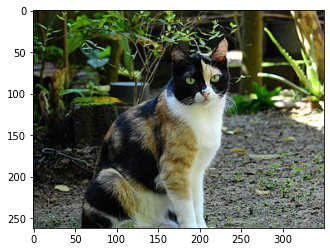

In [68]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_RGB2BGR))
plt.show()

## - 시맨틱 세그멘테이션

In [69]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(262, 350, 3) (384, 513, 3) 8


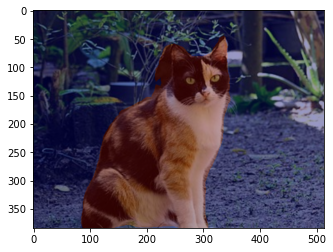

In [70]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## - 셸로우 포커스

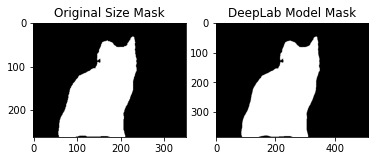

In [71]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

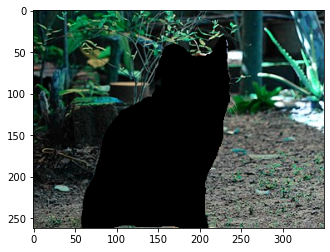

In [72]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

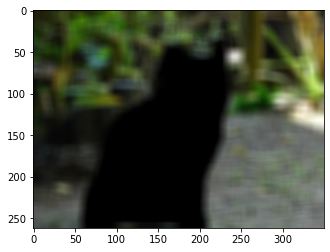

In [73]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

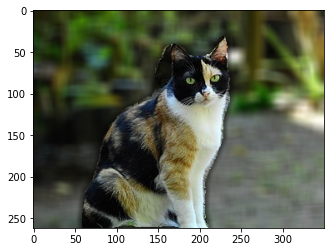

In [74]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
img_concat = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
plt.imshow(img_concat)
plt.show()


In [75]:
import os
backimg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sea.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
backimg_orig = cv2.imread(backimg_path) 
print (backimg_orig.shape)

(291, 480, 3)


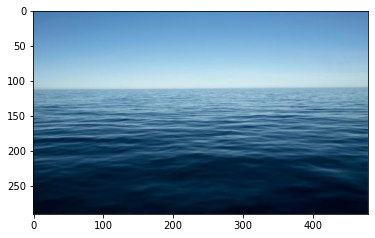

(291, 480, 3)


In [76]:
back = cv2.cvtColor(backimg_orig, cv2.COLOR_BGR2RGB)
plt.imshow(back)
plt.show()
print(back.shape)

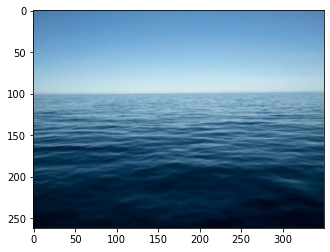

In [77]:
back = cv2.resize(back, (width, height))
plt.imshow(back)
plt.show()

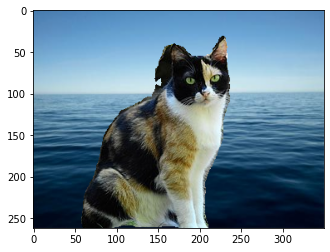

In [78]:
result = cv2.bitwise_and(back, img_mask_color)
result = np.where(img_mask_color==0, back, img_concat)
plt.imshow(result)
plt.show()

## - 고양이 & 사람

In [117]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_and_human.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
height, width, _ = img_orig.shape
print (img_orig.shape)

(427, 640, 3)


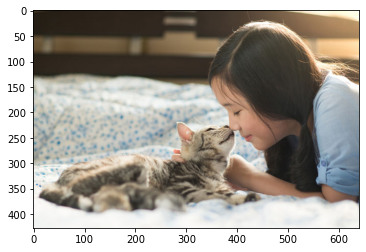

In [118]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_RGB2BGR))
plt.show()

## - 시맨틱 세그멘테이션

In [119]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(427, 640, 3) (342, 513, 3) 15


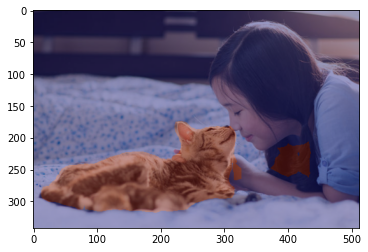

In [120]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## - 셸로우 포커스

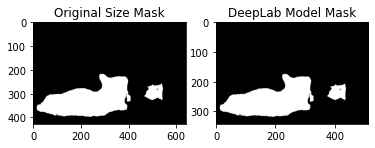

In [121]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

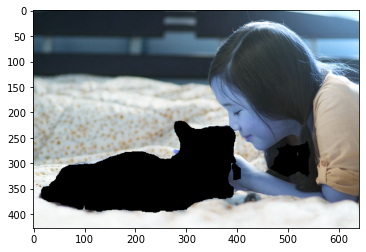

In [122]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

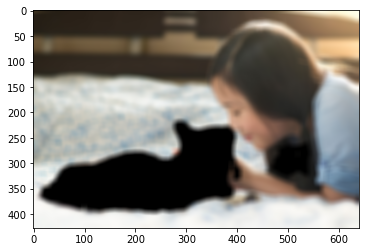

In [123]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

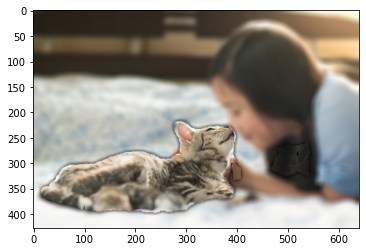

In [124]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
img_concat = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
plt.imshow(img_concat)
plt.show()


In [125]:
import os
backimg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sea.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
backimg_orig = cv2.imread(backimg_path) 
print (backimg_orig.shape)

(291, 480, 3)


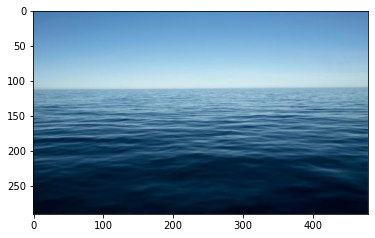

(291, 480, 3)


In [126]:
back = cv2.cvtColor(backimg_orig, cv2.COLOR_BGR2RGB)
plt.imshow(back)
plt.show()
print(back.shape)

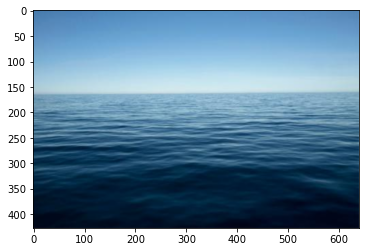

In [127]:
back = cv2.resize(back, (width, height))
plt.imshow(back)
plt.show()

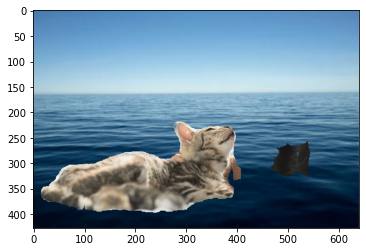

In [128]:
result = cv2.bitwise_and(back, img_mask_color)
result = np.where(img_mask_color==0, back, img_concat)
plt.imshow(result)
plt.show()

## Step 2. 사진에서 문제점 찾기
그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

아래 사진에도 문제점이 몇가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

- 찾은 사물의 경계 부분에 선이 생김
- 사물을 찾을 때 뒷 배경과 비슷한 색상이나 명암 부분이 찾고자 하는 사물로 인식되어 모호해 짐
- 너무 어두운 사진의 경우 사물을 잘 찾기 못함
- 여러가지 물체가 있는 이미지에서 엉뚱한 부분을 사물로 인식
- 동시에 사람과 고양이를 찾는 시도(실패)

## Step 3. 해결 방법을 제안해 보기
아주 간단히 멋진 카메라앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

생각해 볼만한 주제를 아래에 몇가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

### 세그멘테이션의 한계
Semantic segmentation의 부정확성이 여러가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

### 피사계 심도 이해하기
우선 피사계심도의 개념부터 명확히 이해해 봅시다.

참고자료 : https://ggyul.tistory.com/12

### 3D Depth Camera 활용하기
카메라 2개를 통해 생성한 3d 영상으로 인물모드를 더 정확하게 만들 수 있을까요? 우리는 카메라 1대가 찍은 영상에서 semantic segmentation을 시도하였고, 그 결과가 정확하지 않았습니다. 요즘 스마트폰의 카메라는 렌즈가 2개 달려있지요? 왜 굳이 그렇게까지 하는지 아래 링크를 보면서 이해해 봅시다.

참고자료 : https://m.blog.naver.com/panoptics/221336152952

### 깊이 영상(Depth image) 활용하기
하지만 꼭 카메라가 2개여야 할까요? 아래 이미지는 Struct2Depth 라는 기법을 소개한 Google Brain의 논문에 있는 이미지입니다. 세번째 컬럼이 보다 명확하게 depth에 따른 물체인식을 보여 주는데, 이것은 LiDAR가 없이도 아주 정확한 segmentation을 동반한 depth sensor가 가능함을 보여줍니다.

참고자료 : https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6
참고자료 : https://sites.google.com/view/struct2depth


### IR(적외선)을 활용한 사례
구글 pixel4에 IR 카메라가 달려있는데, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.

참고자료 : https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html

엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요. 가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!

## ◈ 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항/상세기준
1. 인물모드 사진을 성공적으로 제작하였다.
아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.

2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

## ◈ 결과 및 고찰

이미지 처리를 위해서 사진을 준비하는 시간이 오래 걸렸다.  
적절한 실험을 위해서는 다양한 이미지가 필요한데 이미지 특성과 과제가 잘 부합되는 것이 중요하였다.  
턴서플로우의 모델을 다운 받아 LABEL_NAMES을 사용할 수 있다는 것이 신기하였으나, 처음 찾고자 하는 사물의 라벨이 정해져 있음을 간과하여 다른 사진 이미지에서 물체를 찾지 못하는 문제가 있었다.  
또한, 한 사진에서 여러 개의 물체를 찾을 수 있는지 시도해 보고 싶어서 해보았으나, 실패하였다. 한 이미지 상에 복잡한 패턴이 있는 경우, 모델이 잘 작동하지 않는 문제가 있었다. 